# IMPORTS

In [51]:
import math
import inflection
import datetime

import pandas              as pd
import numpy               as np
import matplotlib.pyplot   as plt
import seaborn             as sns
import xgboost             as xgb
import matplotlib.gridspec as gridspec

# Setting plot size in the form 'width, lenght' (applies to plt and sns)
plt.rcParams['figure.figsize'] = 20,10

from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats
from tabulate              import tabulate
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## Helper functions

In [52]:
def cramerv(x, y):
    ct = pd.crosstab( x, y ).values
    r, k = ct.shape
    n = ct.sum()
    chi2 = stats.chi2_contingency( ct )[0]
    
    # Bias correction to Cramér's V
    chi2corr = max( 0, chi2/n - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / min( kcorr-1,rcorr-1 ) )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat)/y ) )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model name': model_name, 
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list =[]
    mape_list =[]
    rmse_list = []
    
    for k in range(kfold):
        if verbose:
            print( '\nKFold number: {}'.format(k) )
        validation_date_start = x_training.loc[:,'date'].max() - datetime.timedelta( weeks=(k+1)*6 )
        validation_date_end = x_training.loc[:,'date'].max() - datetime.timedelta( weeks=k*6 ) 
        
        training = x_training.loc[x_training.loc[:,'date'] < validation_date_start,:]
        validation = x_training.loc[(x_training.loc[:,'date'] >= validation_date_start) & (x_training.loc[:,'date'] <= validation_date_end),:]
        
        # Preparing datasets
        # Features
        xtraining = training.drop( columns=['date','sales'] )
        xvalidation = validation.drop( columns=['date','sales'] )
        
        # Target
        ytraining = training.loc[:,'sales']
        yvalidation = validation.loc[:,'sales']
        
        # Model
        m = model.fit( xtraining, ytraining )
        
        # Prediction
        yhat_m = m.predict( xvalidation )
        
        # Performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat_m ) )
        
        # Store each performance metric into list
        mae_list.append( m_result.loc[0,'MAE'] )
        mape_list.append( m_result.loc[0,'MAPE'] )
        rmse_list.append( m_result.loc[0,'RMSE'] )
        
    return pd.DataFrame( {'Model name': model_name,
                          'MAE CV': str( np.round( np.mean( mae_list ), 2 ) ) + ' +/- ' + str( np.round( np.std( mae_list ), 2 ) ),
                          'MAPE CV': str( np.round( np.mean( mape_list ), 2 ) ) + ' +/- ' + str( np.round( np.std( mape_list ), 2 ) ),
                          'RMSE CV': str( np.round( np.mean( rmse_list ), 2 ) ) + ' +/- ' + str( np.round( np.std( rmse_list ), 2 ) )}, index=[0] )

## Loading data

In [3]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
df_stores_raw = pd.read_csv( '../data/store.csv', low_memory=False )

In [4]:
df_sales_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
df_stores_raw

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [6]:
df_raw = pd.merge( df_sales_raw, df_stores_raw, how='left', on='Store')

In [7]:
# Checking if the merging went fine
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
440746,1107,1,2014-06-02,11542,957,1,1,0,0,a,a,1400.0,6.0,2012.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# DATA DESCRIPTION

In [8]:
# Making a security copy
df2 = df_raw.copy()

## Renaming columns

In [9]:
df2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

df2.columns = cols_new

In [11]:
# Checking whether the renaming went fine
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data dimensions

In [12]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## Data types

In [13]:
df2['date'] = pd.to_datetime( df2['date'] )
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Checking NAs

In [14]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Filling out NAs

In [15]:
# competition_distance
df2['competition_distance'].max()

75860.0

In [16]:
# Filling NaN with a value much bigger than the maximum above
df2['competition_distance'] = df2['competition_distance'].apply(lambda x: 300000 if math.isnan(x) else x)
df2['competition_distance'].isna().sum()

0

In [17]:
#competition_open_since_month
df2['competition_open_since_month'] = df2.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df2['competition_open_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df2['promo2_since_week'] = df2.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df2['promo2_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

In [18]:
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['date'].dt.month.map( month_map )

df2['promo_interval'].fillna( 0, inplace=True )

df2['is_promo2'] =  df2[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1)

In [19]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo2                       0
dtype: int64

## Data types (2)

In [20]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

In [21]:
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( np.int64 )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( np.int64 )
df2['promo2_since_week'] = df2['promo2_since_week'].astype( np.int64 )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( np.int64 )

In [22]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

## Descriptive statistics

In [23]:
num_attributes = df2.select_dtypes( include=['int64','float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### Numerical attributes

In [24]:
# Central tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.min() ).T
d3 = pd.DataFrame( num_attributes.max() ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.skew() ).T
d6 = pd.DataFrame( num_attributes.kurtosis() ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [25]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,300000.0,299980.0,6195.172978,2330.0,16856.983808,14.003340,237.337110
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


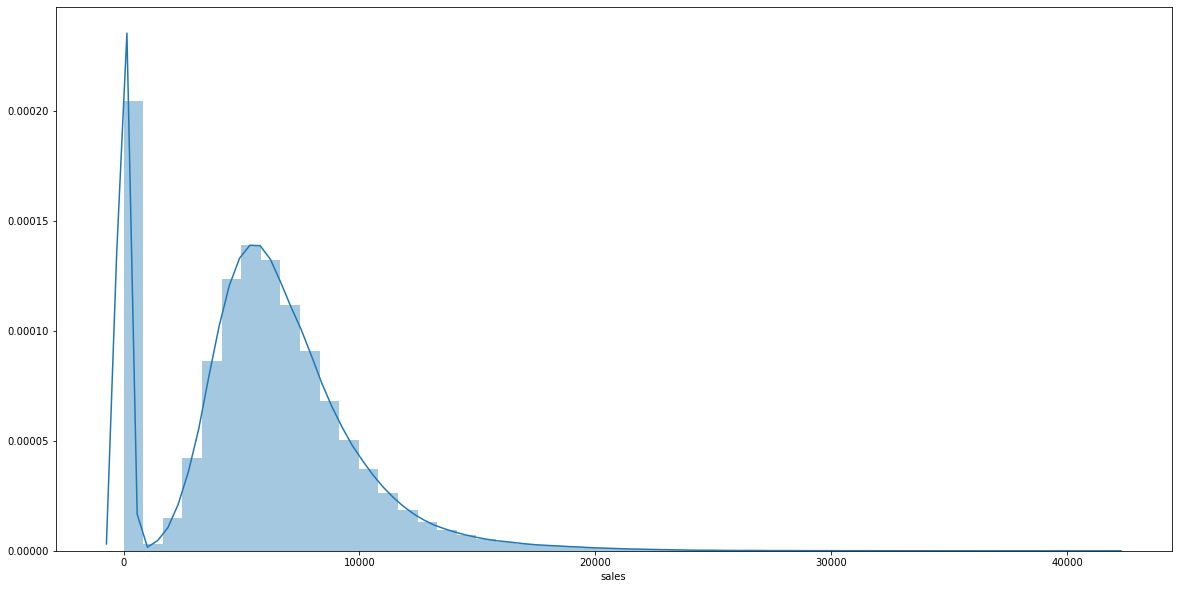

In [26]:
sns.distplot( df2['sales'] );

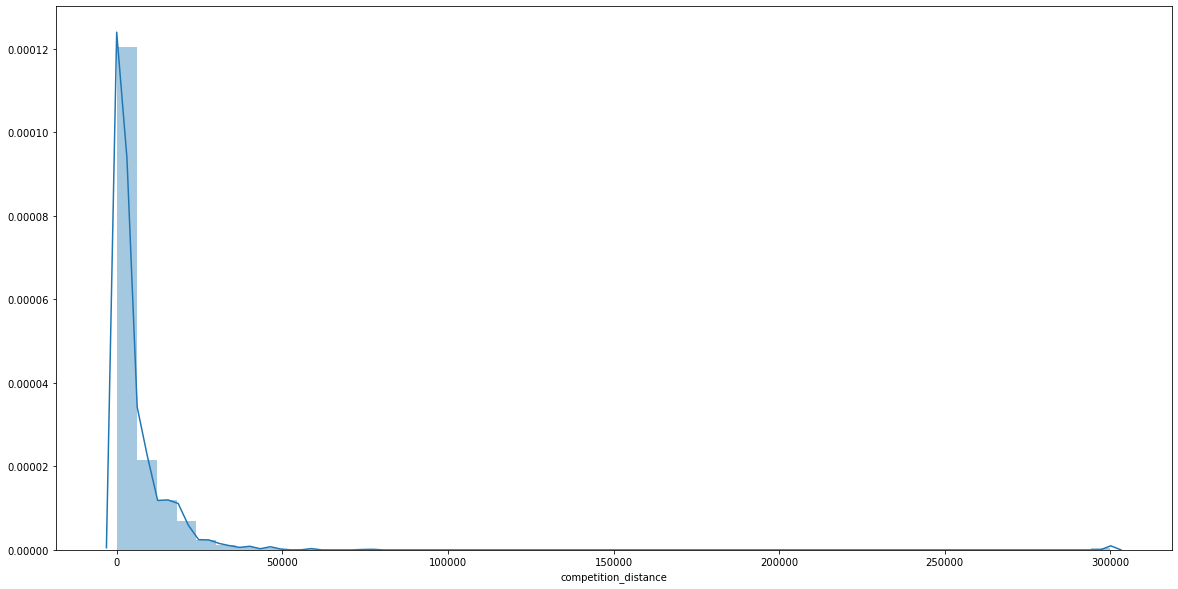

In [27]:
sns.distplot( df2['competition_distance'] );

### Categorial attributes

In [28]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

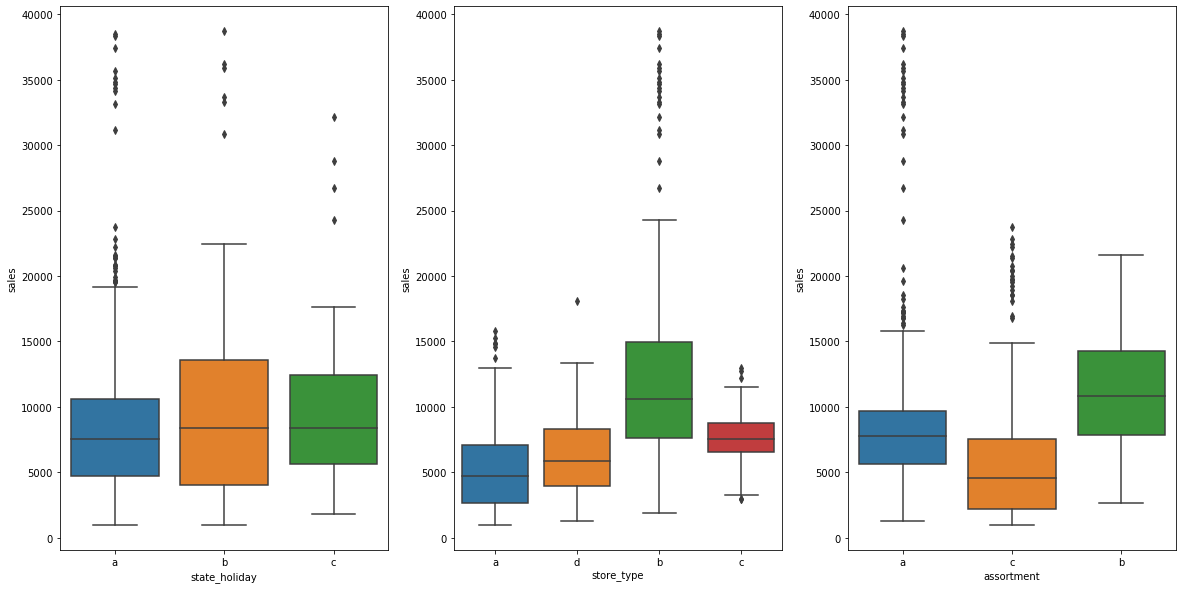

In [29]:
aux1 = df2[( df2['state_holiday'] != '0' ) & ( df2['sales'] > 0 )]

plt.subplot(1, 3, 1);
sns.boxplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot(1, 3, 2);
sns.boxplot( x='store_type', y='sales', data=aux1 );

plt.subplot(1, 3, 3);
sns.boxplot( x='assortment', y='sales', data=aux1 );

# FEATURE ENGINEERING

*In order to come up with business hypotheses, we start with a mind map of the problem, its agents and influencing factors*

In [30]:
df3 = df2.copy()

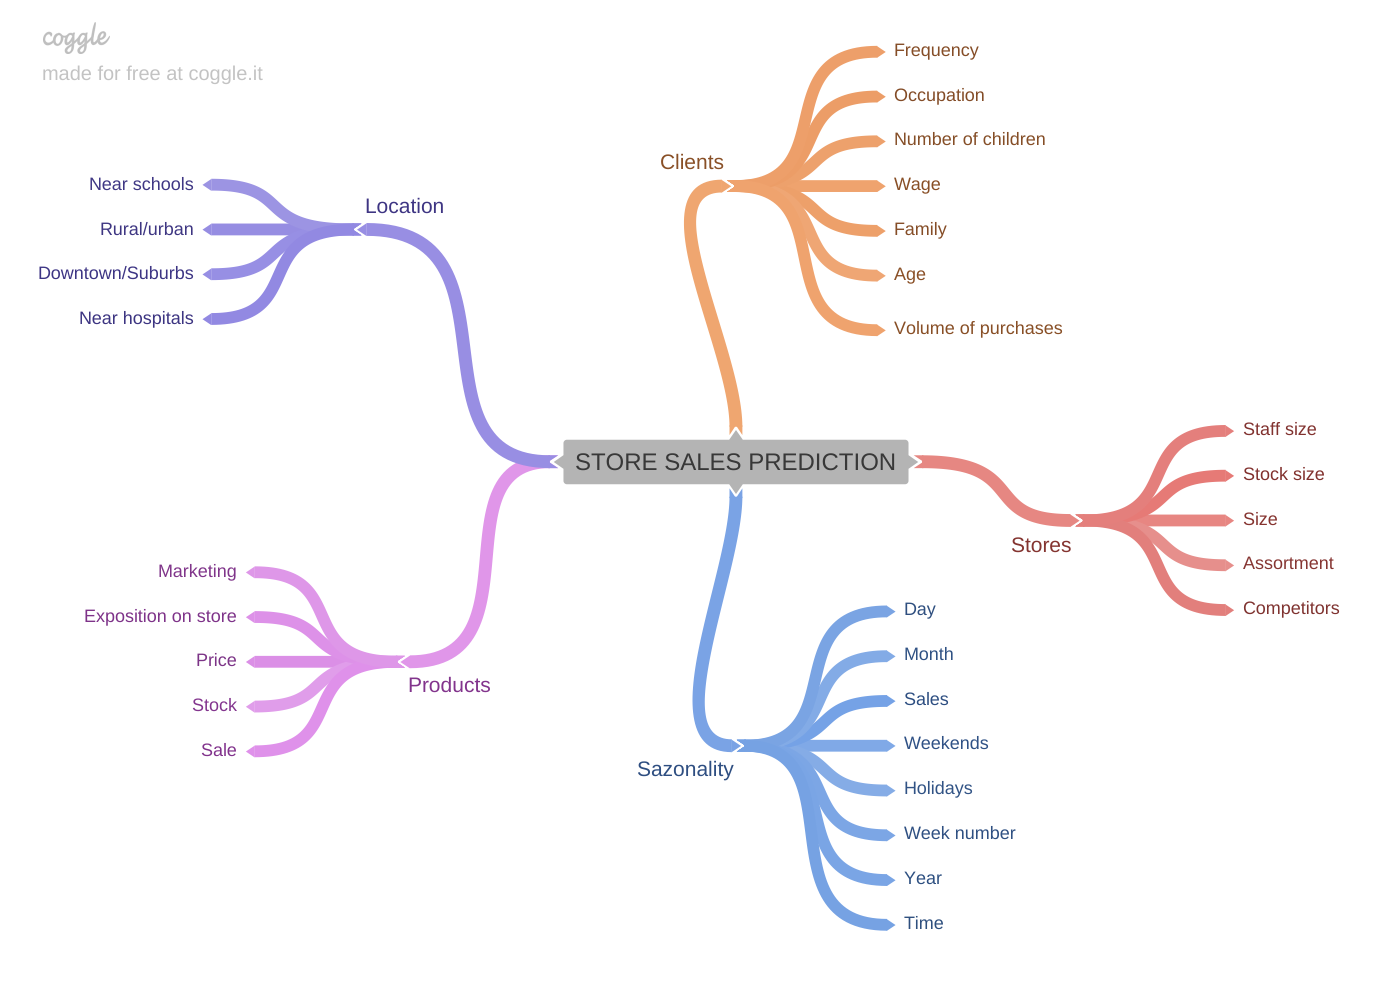

In [31]:
Image( '../imgs/STORE_SALES_PREDICTION.png', width=900 )

## Creation of the hypoteshes

### Stores

**Bigger revenue if:**

**1.** Bigger staff size

**2.** Bigger stock size 

**3.** Larger stores

**4.** Greater assortment

**5.** Older competitors

**Smaller revenue if:**

**6.** Closer competitors

### Products

**Bigger revenue if:**

**1.** Greater marketing investment 

**2.** Better exposition at store 

**3.** Lower prices 

**4.** More agressive sales

**5.** Sales kept for longer periods

**6.** More sales days

**7.** More consecutive sales

### Sazonality

**Smaller revenue during:**

**1.** School holidays

**2.** Weekends
     
**Bigger revenue:**

**3.** If open during Christmas 

**4.** With the passage of years

**5.** On the 2nd semester of each year

**6.** After the 10th day of each month

## Final list of hypotheses
*Selecting from the above only the ones possible with the current features*

*Remaining ones are postponed for future cycles of CRISP-DM*

**1.** Greater assortment $\Rightarrow$ bigger revenue

**2.** Older competitors $\Rightarrow$ bigger revenue

**3.** Closer competitors $\Rightarrow$ lower revenue

**4.** Sales kept for longer periods $\Rightarrow$ bigger revenue

**5.** More sales days $\Rightarrow$ bigger revenue

**6.** More consecutive sales $\Rightarrow$ bigger revenue

**7.** School holidays $\Rightarrow$ lower revenue

**8.** Weekends $\Rightarrow$ lower revenue

**9.** If open during Christmas $\Rightarrow$ bigger revenue

**10.** With the passage of years $\Rightarrow$ bigger revenue

**11.** On the 2nd semester of each year $\Rightarrow$ bigger revenue

**12.** After the 10th day of each mont $\Rightarrow$ bigger revenue

## Feature engineering

In [32]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# year week
df3['year_week'] = df3['date'].dt.strftime( '%Y-%W' )

# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
# competition time (months)
df3['competition_time_month'] = ( ( df3['date'] - df3['competition_since'] )/30 ).dt.days

# promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( weeks=1 ) )
# promo time (weeks)
df3['promo_time_week'] = ( ( df3['date'] - df3['promo_since'] )/7 ).dt.days

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

# state holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# FILTERING VARIABLES

*Ruling out a subset of the data due to business restrictions*

In [33]:
df4 = df3.copy()

In [34]:
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## Filtering rows

In [35]:
# Information about closed stores are not actually useful here 
# Moreover, only data for which sales occurred are really relevant
df4 = df4.loc[(df4['open'] != 0) & (df4['sales'] > 0)]

## Selecting columns

In [36]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df4.drop( columns=cols_drop, inplace=True )

In [37]:
df4.sample()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
462496,557,2,2014-05-13,3526,0,regular_day,0,a,basic,250.0,...,0,2014,5,13,20,2014-19,2014-05-01,0,2014-05-12,0


# EDA

In [38]:
df5 = df4.copy()

## Univariate analysis

### Response variable

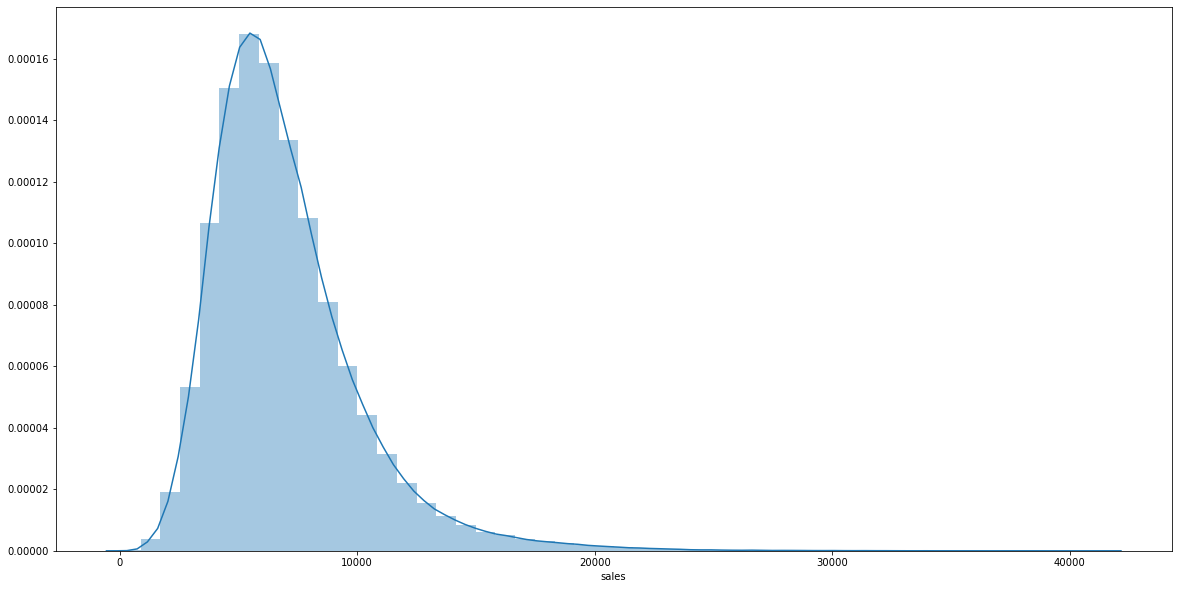

In [39]:
sns.distplot( df5['sales'] );

### Numerical variables

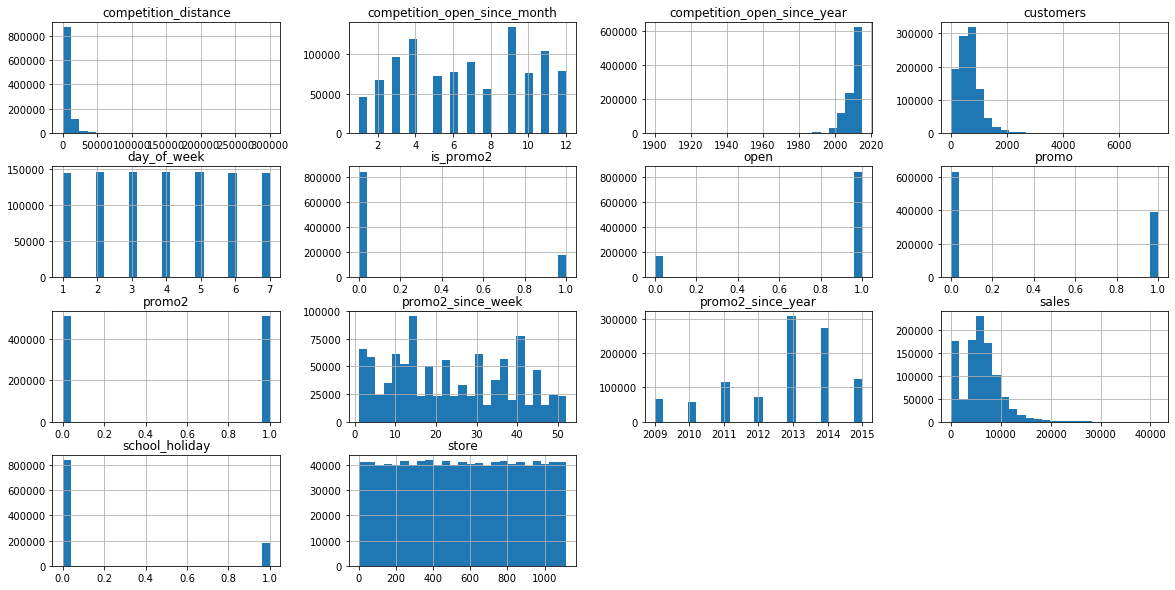

In [40]:
num_attributes.hist( bins=25 );

### Categorical variables

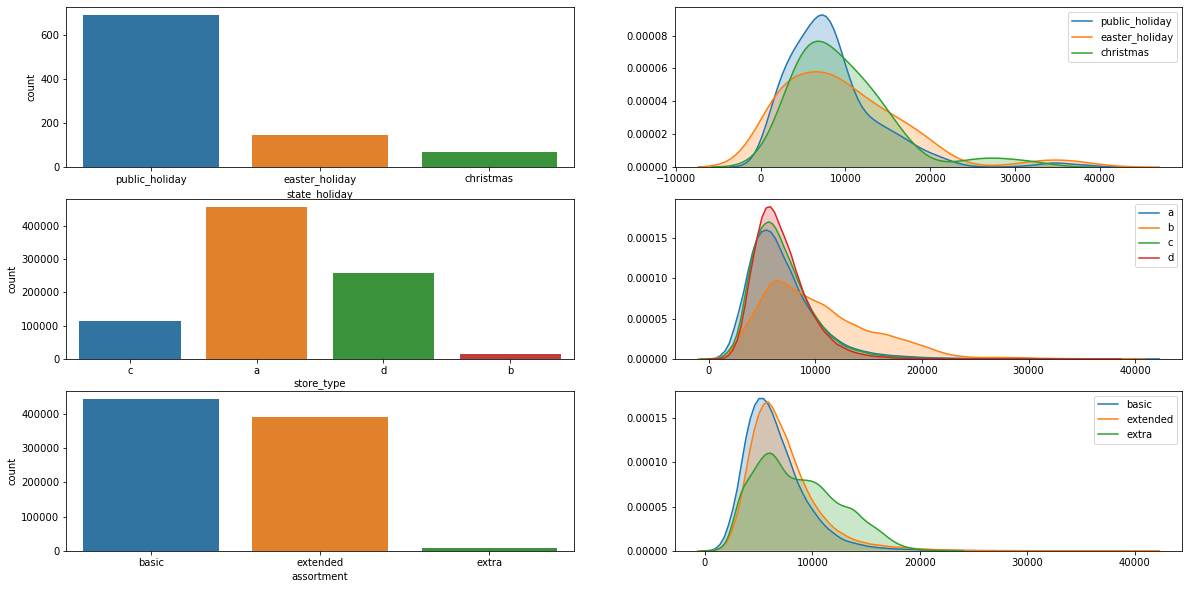

In [41]:
#state_holiday
a = df5[df5['state_holiday'] != 'regular_day']
plt.subplot(3, 2, 1)
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df5['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot( df5[df5['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df5[df5['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df5[df5['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df5[df5['store_type'] == 'd']['sales'], label='d', shade=True )


#assortment
plt.subplot(3, 2, 5)
sns.countplot(df5['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot( df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True )

## Bivariate analysis

### Greater assortment $\Rightarrow$ bigger revenue
_**<span style="color:red">False:</span>**_ **Stores with more ('extra') assortment sell less**

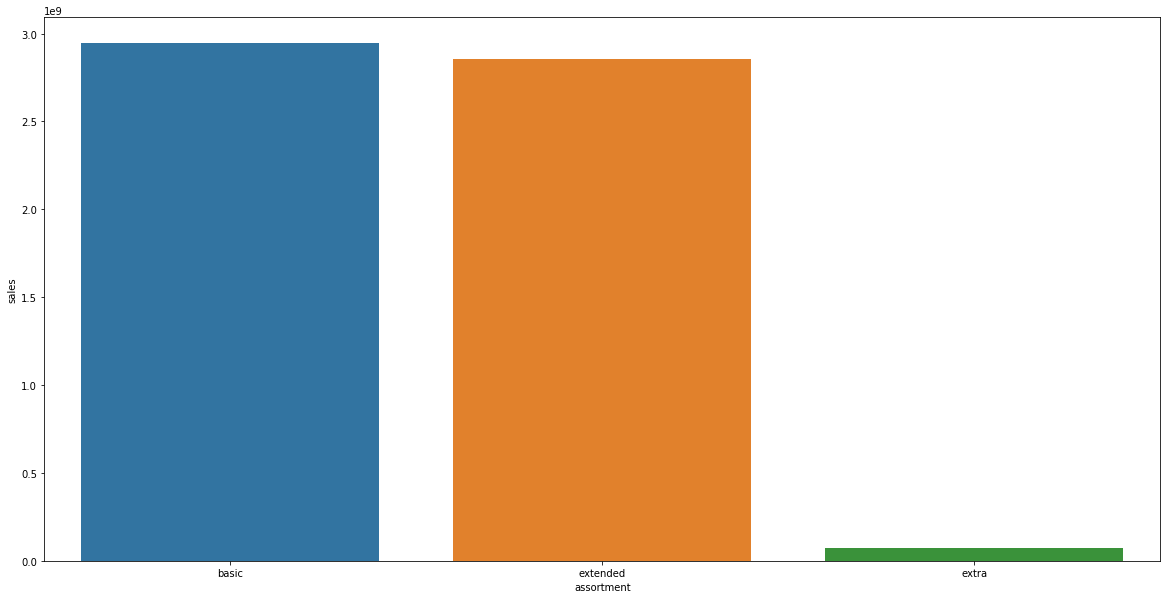

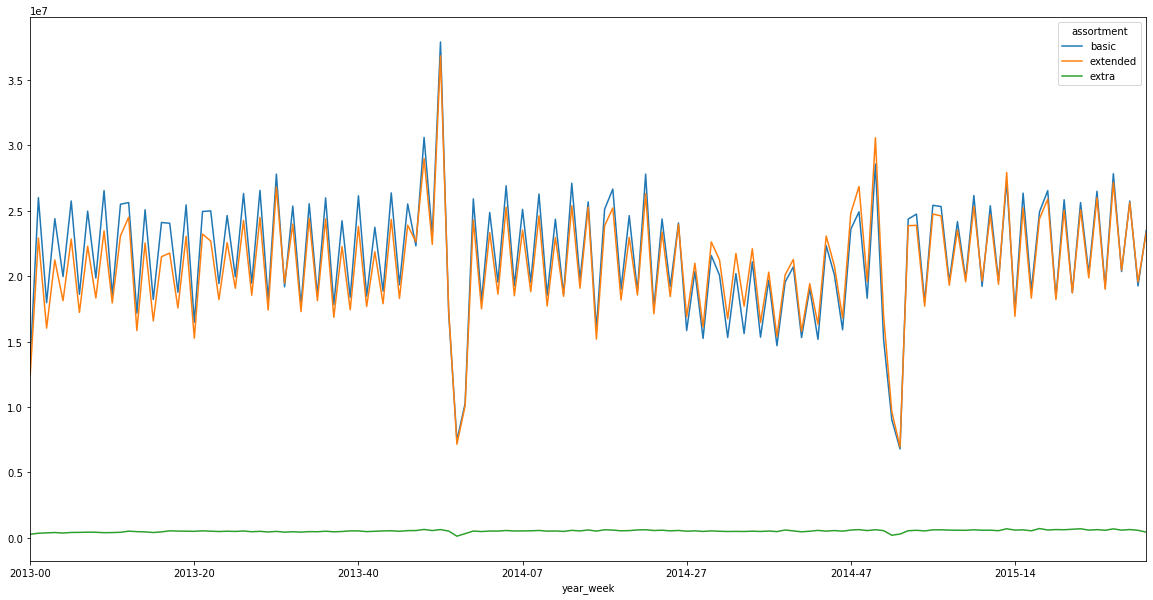

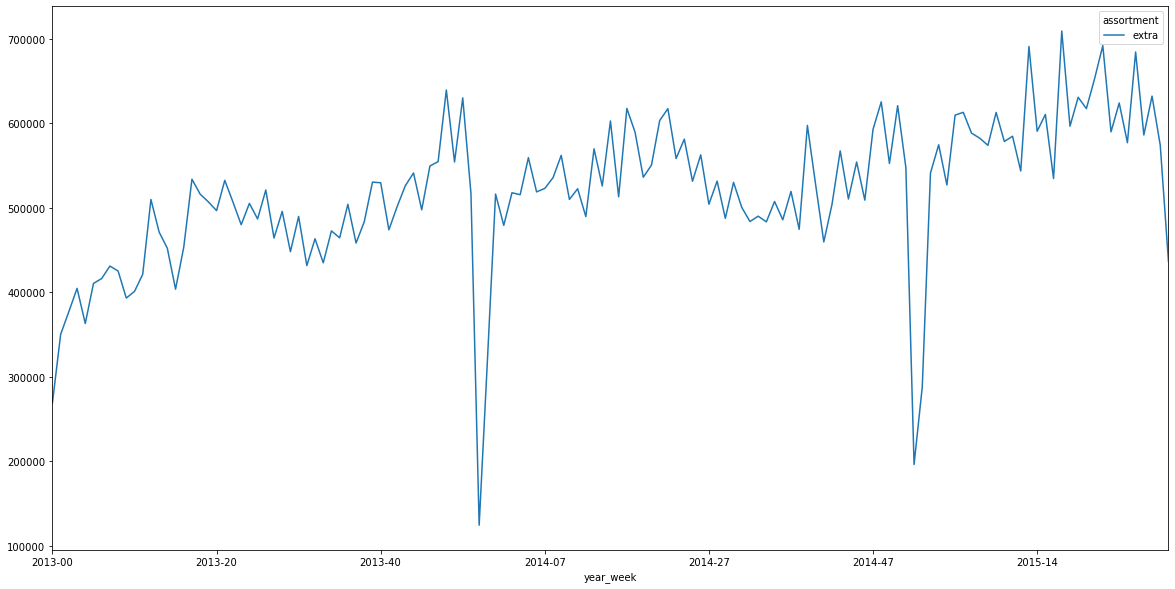

In [42]:
aux1 = df5[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df5[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### Older competitors $\Rightarrow$ bigger revenue
_**<span style="color:red">False:</span>**_ **Stores with older competitors sell less**

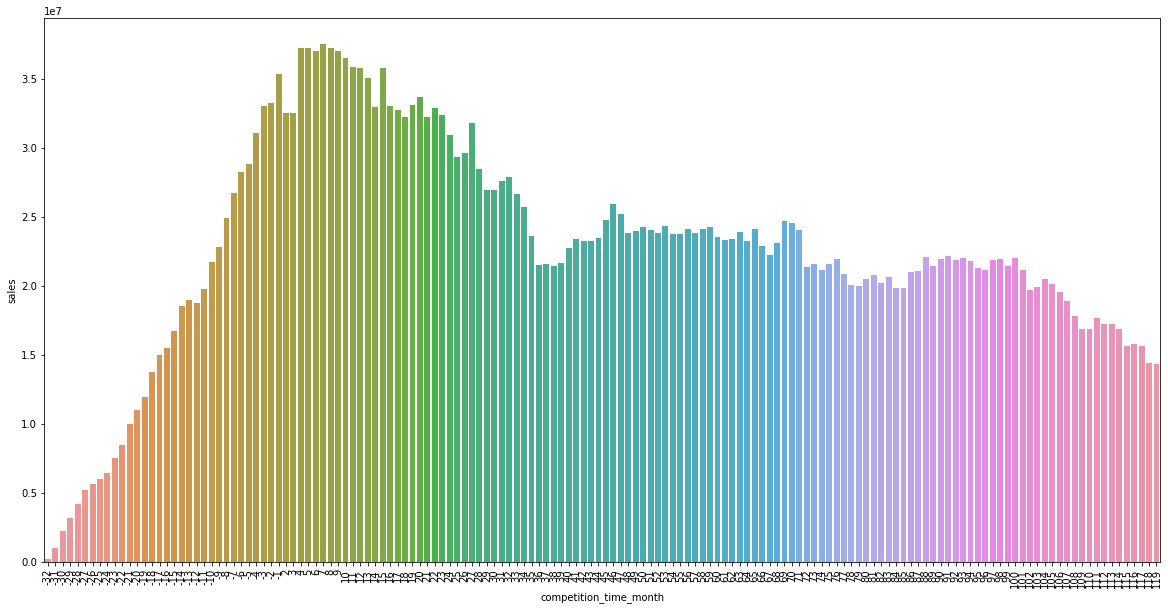

In [43]:
aux7 = df5.loc[:,['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()

# In the following, I exclude '0' and '1' since they might come from the previous substitution of NA values 
#                                                                         for 'competition_since' variables
# It is not guaranteed whether I am also excluding previously OK (not NA) data

aux8 = aux7.loc[(aux7['competition_time_month'] < 120) & (aux7['competition_time_month'] != 0) & (aux7['competition_time_month'] != 1),:]
sns.barplot( x='competition_time_month', y='sales', data=aux8 );
plt.xticks( rotation=90 );

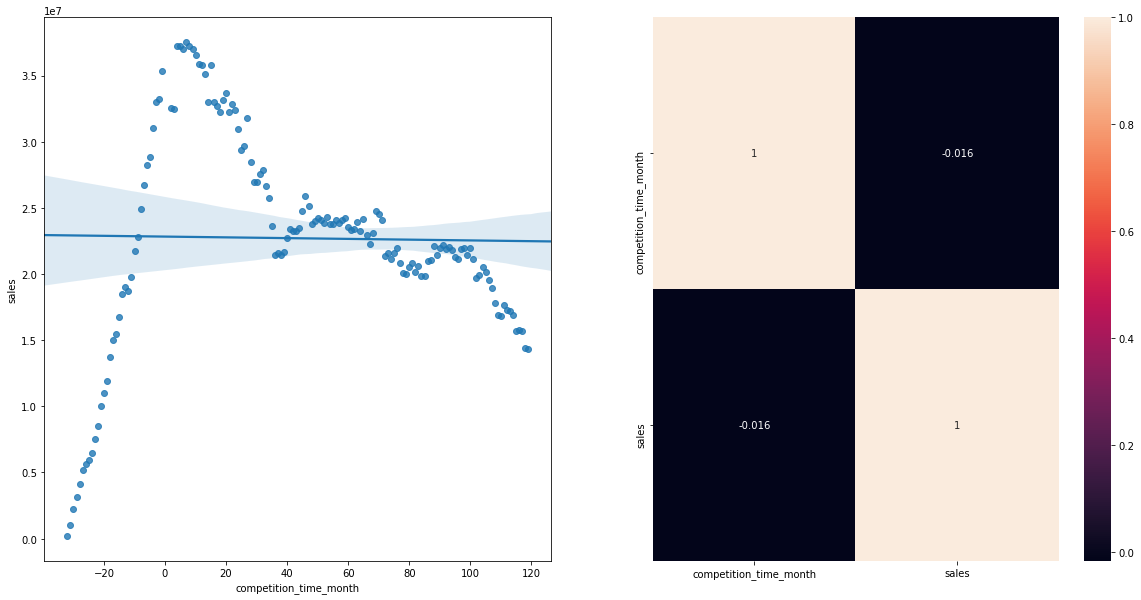

In [44]:
plt.subplot(1,2,1);
sns.regplot( x='competition_time_month', y='sales', data=aux8 );


plt.subplot(1,2,2);
sns.heatmap( aux8.corr(method='pearson'), annot=True );

### Closer competitors $\Rightarrow$ lower revenue
_**<span style="color:red">False:</span>**_ **Stores with competitors in a smaller range seem to sell more! _(this is an unexpected insight)_**

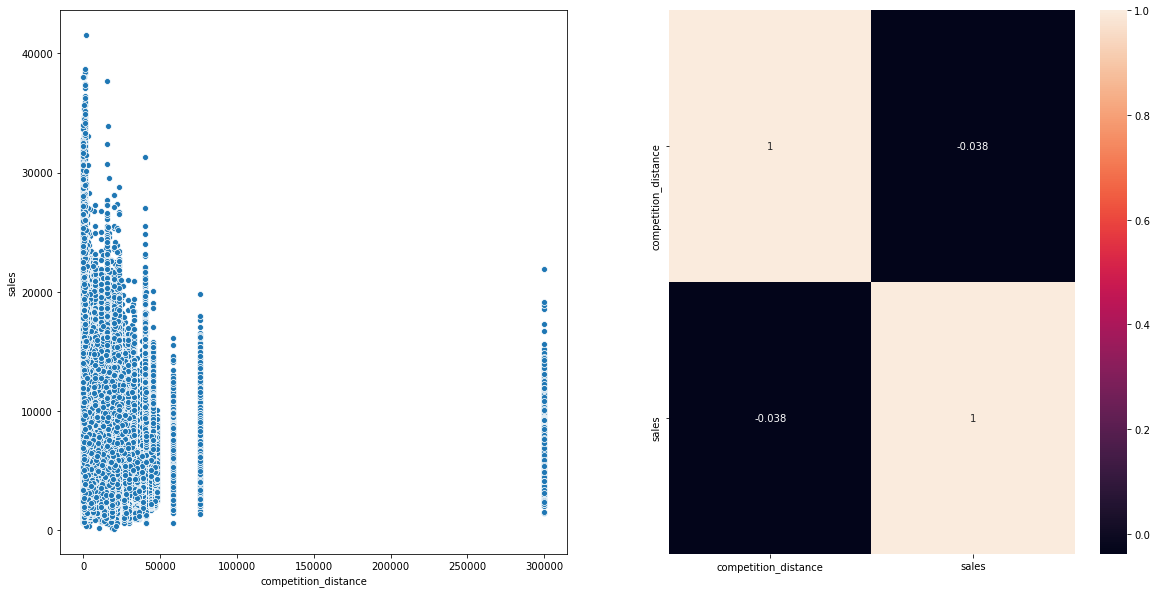

In [45]:
aux4 = df5.loc[:,['competition_distance','sales']]
plt.subplot(1,2,1)
sns.scatterplot( x='competition_distance', y='sales', data=aux4 );

plt.subplot(1,2,2)
sns.heatmap( aux4.corr( method='pearson' ), annot=True );

*Or barplots, divided in 2 subplots to streamline visualization*

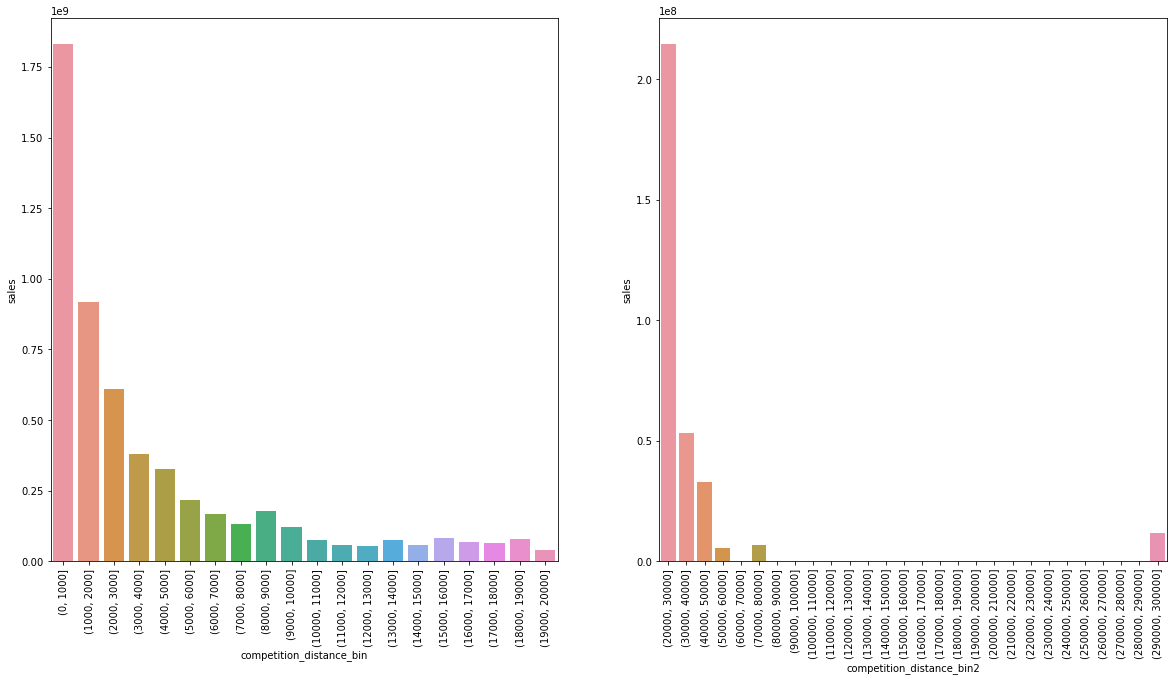

In [46]:
bins = list( np.arange( 0, 20001, 1000 ) )
aux4['competition_distance_bin'] = pd.cut(aux4.loc[:,'competition_distance'], bins=bins)

aux5 = aux4.groupby( 'competition_distance_bin' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot( aux5['competition_distance_bin'], aux5['sales'] );
plt.xticks( rotation=90 );



bins2 = list( np.arange( 20000, 300001, 10000 ) )
aux4['competition_distance_bin2'] = pd.cut(aux4.loc[:,'competition_distance'], bins=bins2)

aux6 = aux4.groupby( 'competition_distance_bin2' ).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot( aux6['competition_distance_bin2'], aux6['sales'] );
plt.xticks( rotation=90 );

### Sales kept for longer periods $\Rightarrow$ bigger income
_**<span style="color:red">False:</span>**_ stores with sales kept for longer periods start to sell less after some time

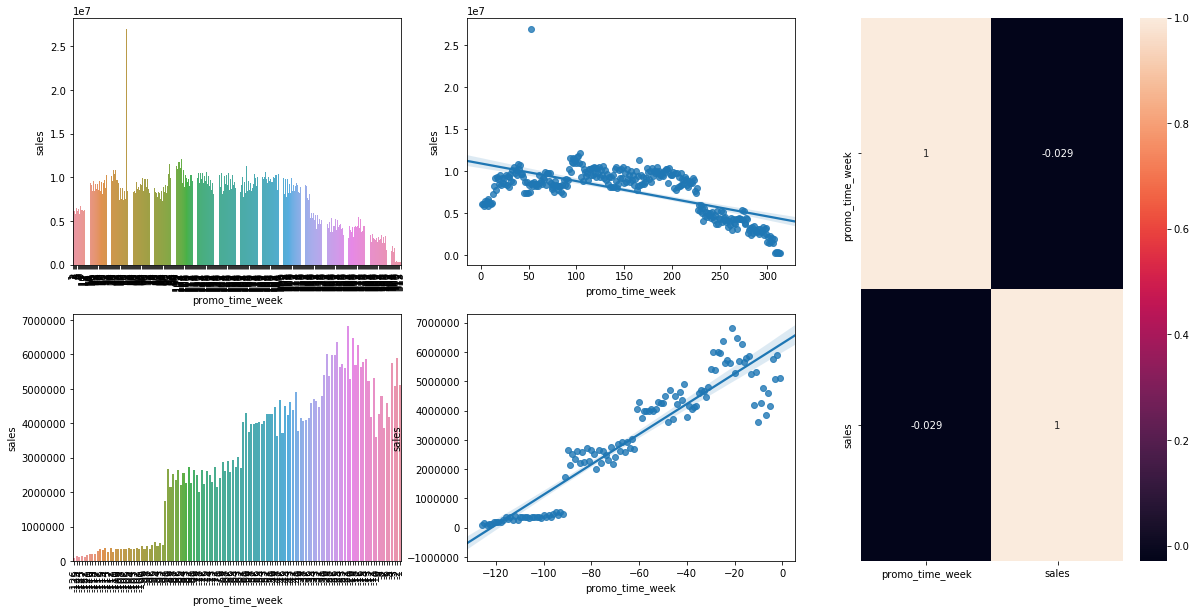

In [56]:
aux9 = df5.loc[:,['sales','promo_time_week']].groupby( 'promo_time_week' ).sum().reset_index()

grid = gridspec.GridSpec( 2, 3 )

aux10 = aux9.loc[aux9.loc[:,'promo_time_week'] > 0,:] # Store is in Promo 2 (extended)
plt.subplot( grid[0,0] );
sns.barplot( x='promo_time_week', y='sales', data=aux10 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1]);
sns.regplot( x='promo_time_week', y='sales', data=aux10 );

aux11 = aux9.loc[aux9.loc[:,'promo_time_week'] < 0,:] # Store is in Promo 1 (standard)
plt.subplot( grid[1,0] );
sns.barplot( x='promo_time_week', y='sales', data=aux11 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1]);
sns.regplot( x='promo_time_week', y='sales', data=aux11 );


plt.subplot( grid[:,2] );
sns.heatmap( aux9.corr( method='pearson' ), annot=True);

### <s>More sales days $\Rightarrow$ bigger income</s>
Left for the next CRISP-DM cycle, since it would require the creation of new features

### More consecutive sales $\Rightarrow$ bigger income
_**<span style="color:red">False:</span>**_ stores which entered Promo 2 had their sales reduced

In [57]:
df5.loc[:,['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


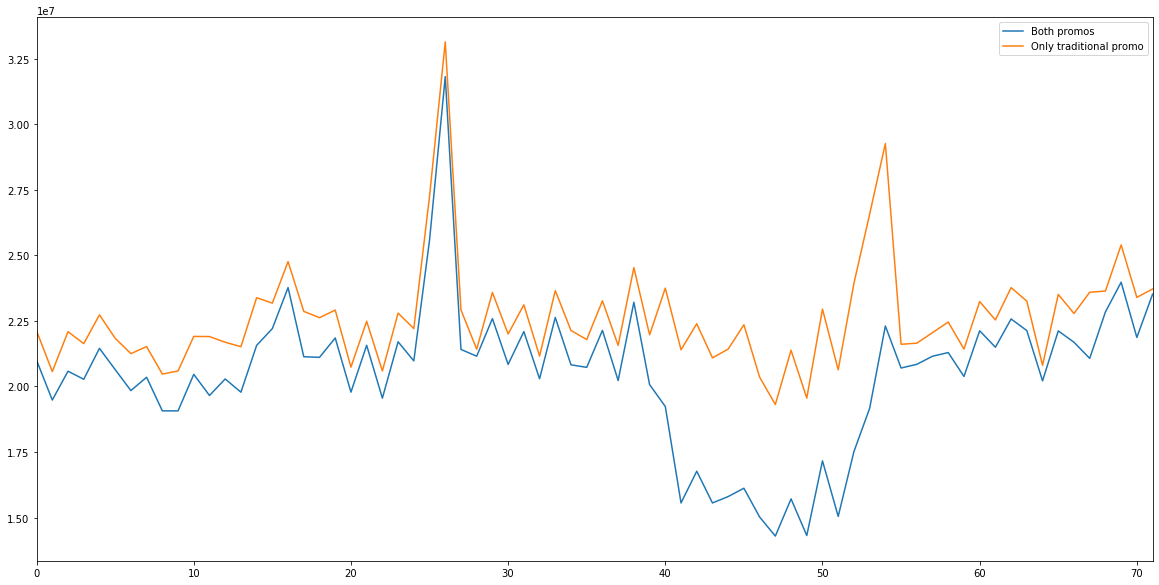

In [58]:
aux12 = df5.loc[(df5['promo'] == 1) & (df5['promo2'] == 1),['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux12.plot();

aux13 = df5.loc[(df5['promo'] == 1) & (df5['promo2'] == 0),['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux13.plot( ax=ax );

ax.legend( labels=['Both promos', 'Only traditional promo'] );

### School holidays $\Rightarrow$ lower income
_**<span style="color:red">Half-true:</span>**_ there is not much income during school holidays, but that is due to there not being much of these holidays. Normalizing by their occurrence, school holidays figure a slightly bigger income than regular school days. This is confirmed comparing the two incomes along the passage of the months

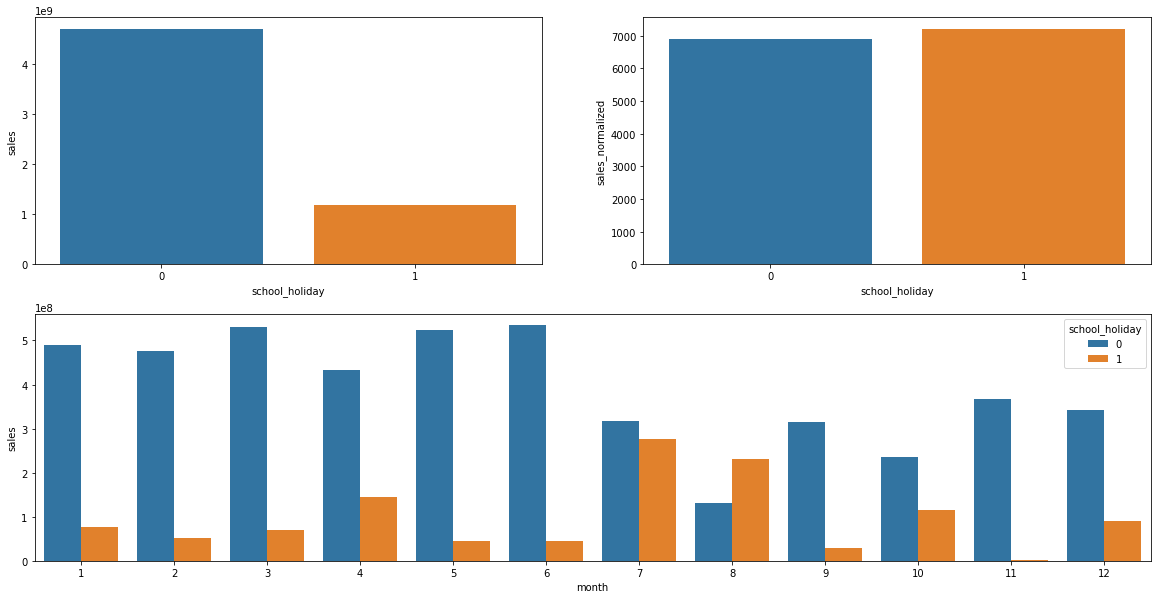

In [59]:
grid = gridspec.GridSpec( 2,2 )

aux = df5.loc[:,['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( grid[0,0] )
sns.barplot( x='school_holiday', y='sales', data=aux );


n_school_holidays = df5.loc[df5['school_holiday'] == 1, :].shape[0]
n_no_school_holidays = df5.loc[df5['school_holiday'] == 0, :].shape[0]

aux.loc[0, 'sales_normalized'] = aux.loc[0,'sales']/n_no_school_holidays
aux.loc[1, 'sales_normalized'] = aux.loc[1,'sales']/n_school_holidays
plt.subplot( grid[0,1] )
sns.barplot( x='school_holiday', y='sales_normalized', data=aux );


aux2 = df5.loc[:,['month','school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( grid[1,:] )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### Store open on weekends $\Rightarrow$ lower income
_**<span style="color:red">True:</span>**_ the stores sell considerably less on the weekends, specially on sundays

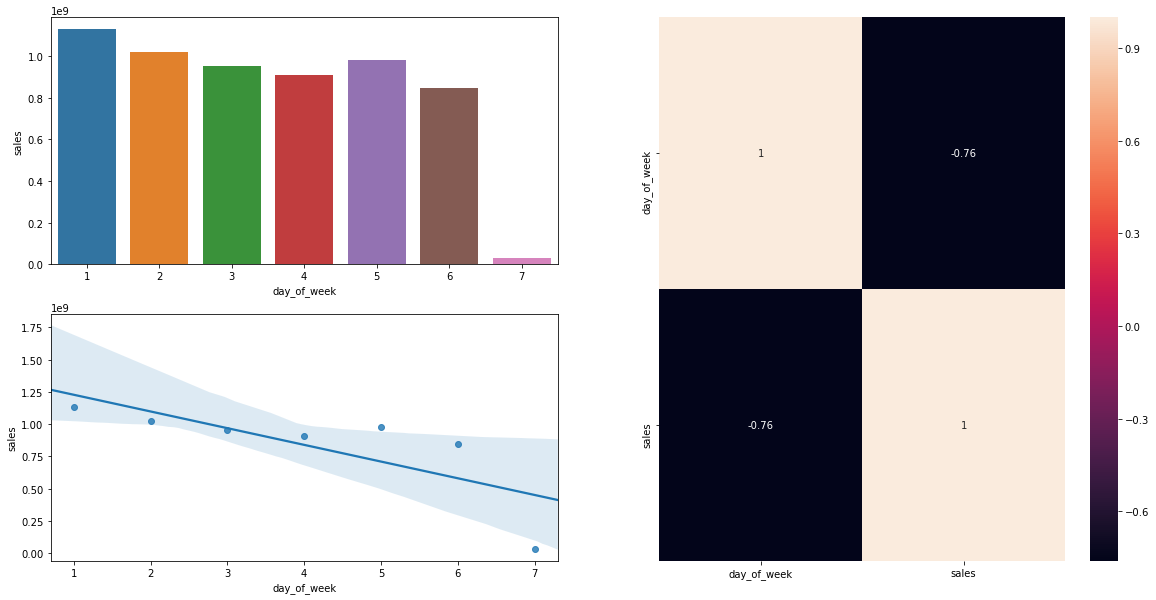

In [60]:
grid = gridspec.GridSpec( 2,2 )

aux = df5.loc[:,['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( grid[0,0] )
sns.barplot( x='day_of_week', y='sales', data=aux );

plt.subplot( grid[1,0] )
sns.regplot( x='day_of_week', y='sales', data=aux );

plt.subplot( grid[:,1])
sns.heatmap( aux.corr( method='pearson' ), annot=True);

### Store open during Christmas $\Rightarrow$ bigger income
_**<span style="color:red">Half-false:</span>**_ there is not much income during Christmas and Easter holidays as compared to public holidays. However, normalizing by their occurrence, the former figure a slightly bigger income than the latter.

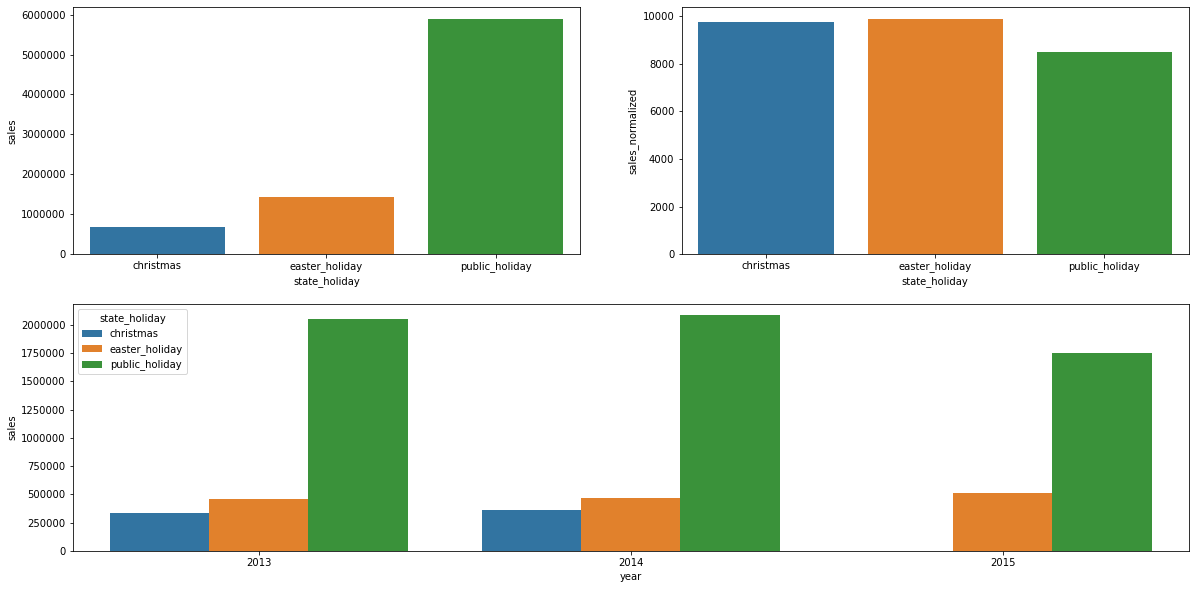

In [61]:
grid = gridspec.GridSpec( 2,2 )

aux = df5.loc[df5['state_holiday'] != 'regular_day', ['state_holiday','sales']].groupby( 'state_holiday' ).sum().reset_index()
plt.subplot( grid[0,0] )
sns.barplot( x='state_holiday', y='sales', data=aux );


n_christmas = df5.loc[df5['state_holiday'] == 'christmas', :].shape[0]
n_easter = df5.loc[df5['state_holiday'] == 'easter_holiday', :].shape[0]
n_public_holidays = df5.loc[df5['state_holiday'] == 'public_holiday', :].shape[0]

aux.loc[0, 'sales_normalized'] = aux.loc[0,'sales']/n_christmas
aux.loc[1, 'sales_normalized'] = aux.loc[1,'sales']/n_easter
aux.loc[2, 'sales_normalized'] = aux.loc[2,'sales']/n_public_holidays
plt.subplot( grid[0,1] )
sns.barplot( x='state_holiday', y='sales_normalized', data=aux );


aux2 = df5.loc[df5['state_holiday'] != 'regular_day', ['year','state_holiday','sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
plt.subplot( grid[1,:] )
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### Along the passage of years $\Rightarrow$ bigger income
_**<span style="color:red">False:</span>**_ from 2013 to 2014 the overall income dropped. Then from 2014 to 2015 it did so even more pronouncedly, but one has to recall that the 2015 data isn't complete yet.

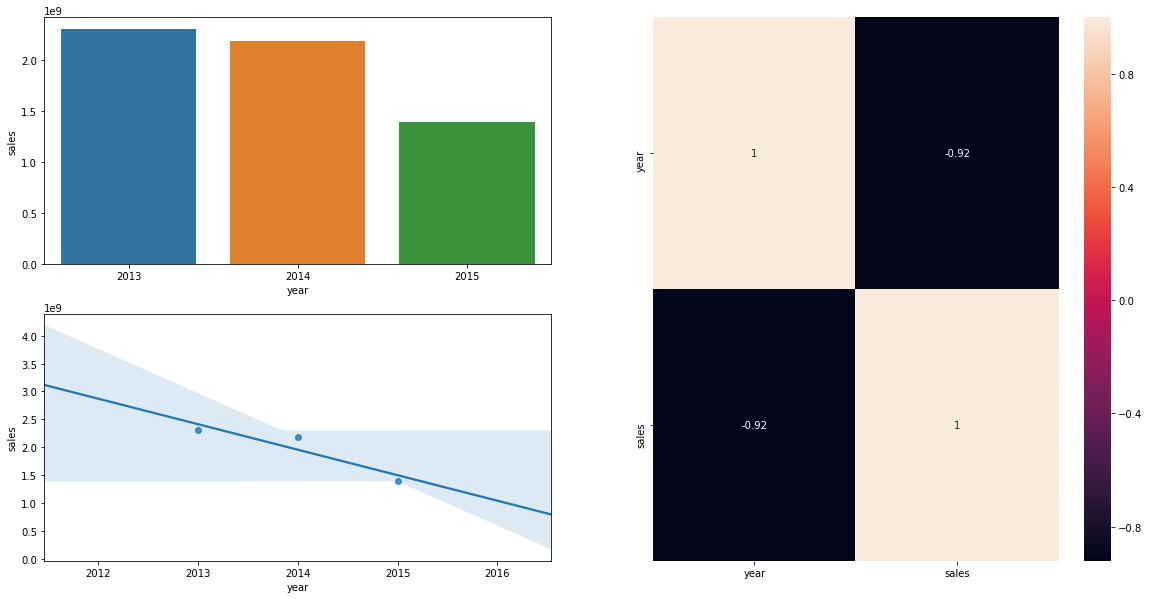

In [62]:
grid = gridspec.GridSpec( 2,2 );

aux = df5.loc[:,['year','sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( grid[0,0] )
sns.barplot( x='year', y='sales', data=aux );

plt.subplot( grid[1,0] )
sns.regplot( x='year', y='sales', data=aux );

plt.subplot( grid[:,1] )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

### On the 2nd semester of each year $\Rightarrow$ bigger income
_**<span style="color:red">False:</span>**_ upon close inspection, one sees there isn't great variation on the income along the months of the year

**At first glance, it would seem the 2nd semester figures a lower income. However, one has to recall again that the 2015 data isn't complete**

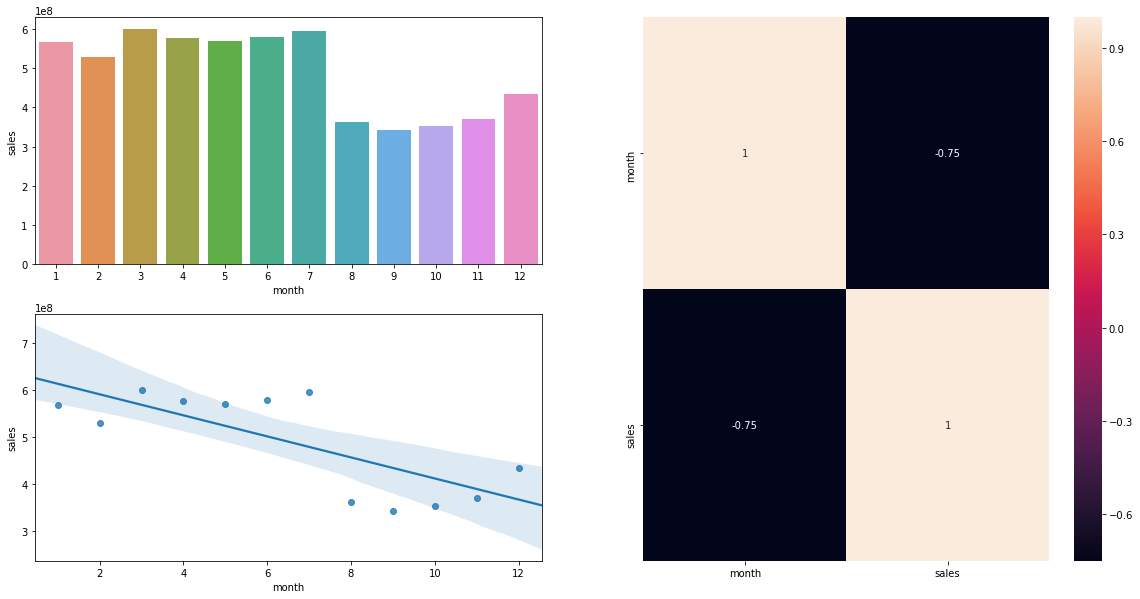

In [63]:
grid = gridspec.GridSpec( 2,2 )

aux = df5.loc[:,['month','sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( grid[0,0] )
sns.barplot( x='month', y='sales', data=aux );

plt.subplot( grid[1,0] )
sns.regplot( x='month', y='sales', data=aux );

plt.subplot( grid[:,1] )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

**Filtering out 2015, one sees that there isn't great variation among months**

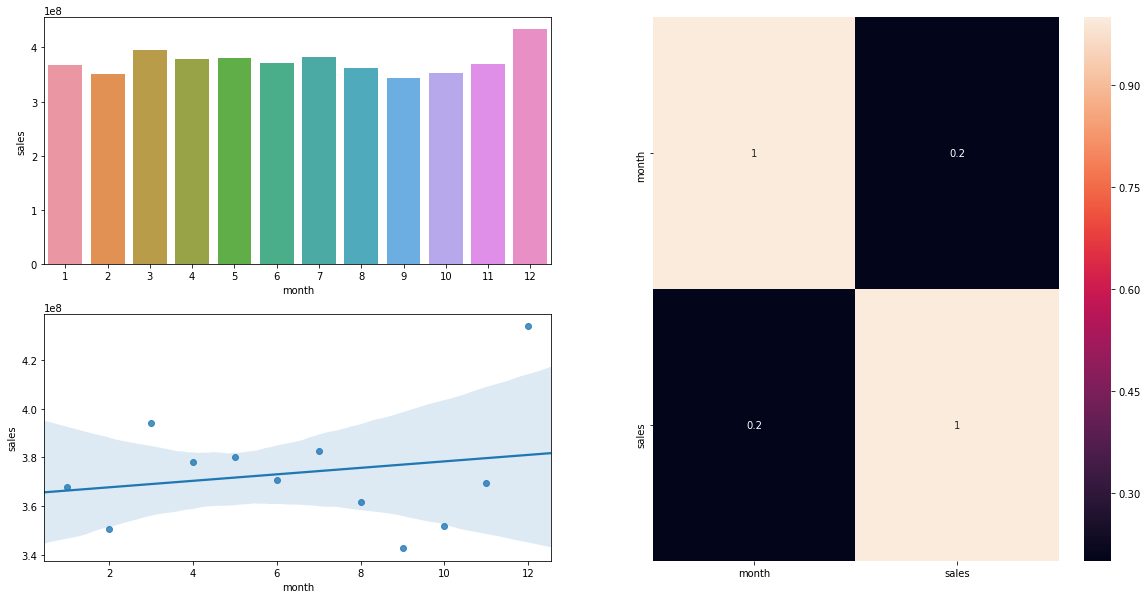

In [64]:
grid = gridspec.GridSpec( 2,2 )

aux = df5.loc[df5['year'] != 2015,['month','sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( grid[0,0] )
sns.barplot( x='month', y='sales', data=aux );

plt.subplot( grid[1,0] )
sns.regplot( x='month', y='sales', data=aux );

plt.subplot( grid[:,1] )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

**And considering only the data up to july (july 2015 is the last part of the set)**

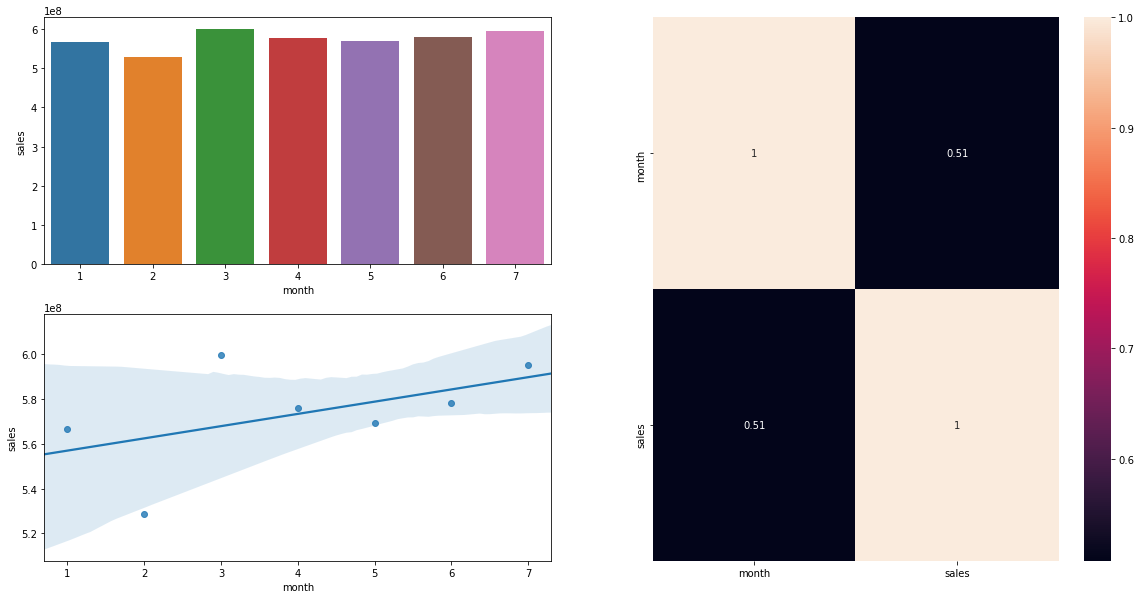

In [65]:
grid = gridspec.GridSpec( 2,2 )

aux = df5.loc[df5['month'] <= 7,['month','sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( grid[0,0] )
sns.barplot( x='month', y='sales', data=aux );

plt.subplot( grid[1,0] )
sns.regplot( x='month', y='sales', data=aux );

plt.subplot( grid[:,1] )
sns.heatmap( aux.corr( method='pearson' ), annot=True );

### After the 10th day of each mont $\Rightarrow$ bigger income
_**<span style="color:red">True:</span>**_ the accumulated income after the 10th day of each month is indeed bigger, even though the average income in the first 10 days is bigger

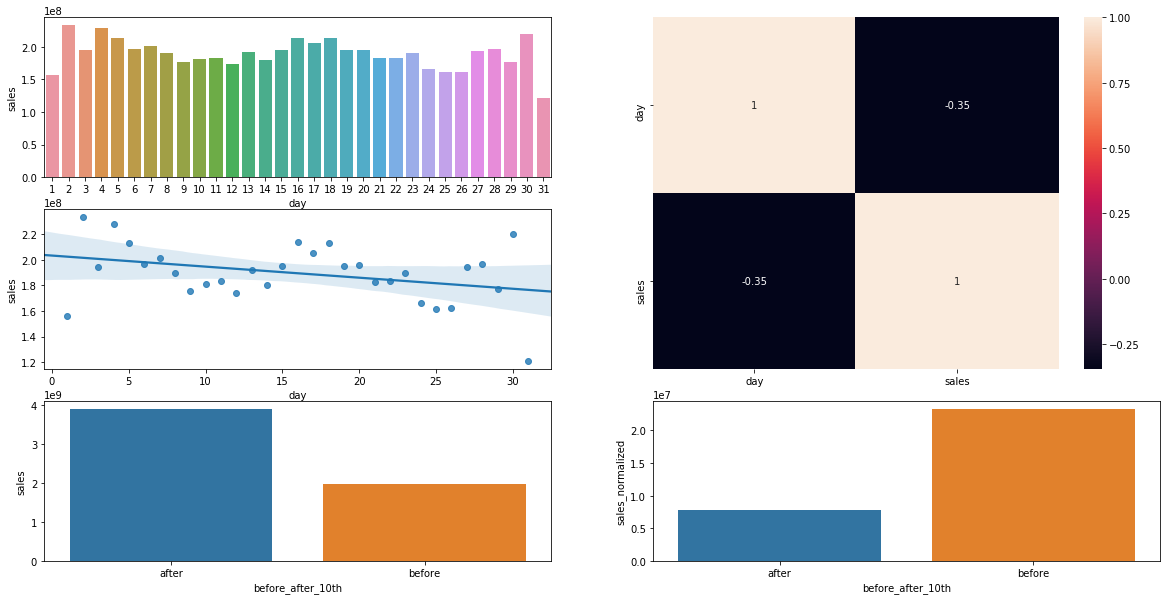

In [66]:
grid = gridspec.GridSpec( 3,2 )

aux = df5.loc[:,['day','sales']].groupby( 'day' ).sum().reset_index()
plt.subplot( grid[0,0] )
sns.barplot( x='day', y='sales', data=aux );

plt.subplot( grid[1,0] )
sns.regplot( x='day', y='sales', data=aux );

plt.subplot( grid[0:2,1] )
sns.heatmap( aux.corr( method='pearson' ), annot=True );


aux['before_after_10th'] = aux['day'].apply( lambda x: 'before' if x<=10 else 'after' )
aux2 = aux[['before_after_10th', 'sales']].groupby( 'before_after_10th' ).sum().reset_index()
plt.subplot( grid[2,0] )
sns.barplot( x='before_after_10th', y='sales', data=aux2 );


aux2.loc[0,'sales_normalized'] = aux.loc[0,'sales']/20
aux2.loc[1,'sales_normalized'] = aux.loc[1,'sales']/10
plt.subplot( grid[2,1] )
sns.barplot( x='before_after_10th', y='sales_normalized', data=aux2 );

## Multivariate analysis

### Numerical attributes

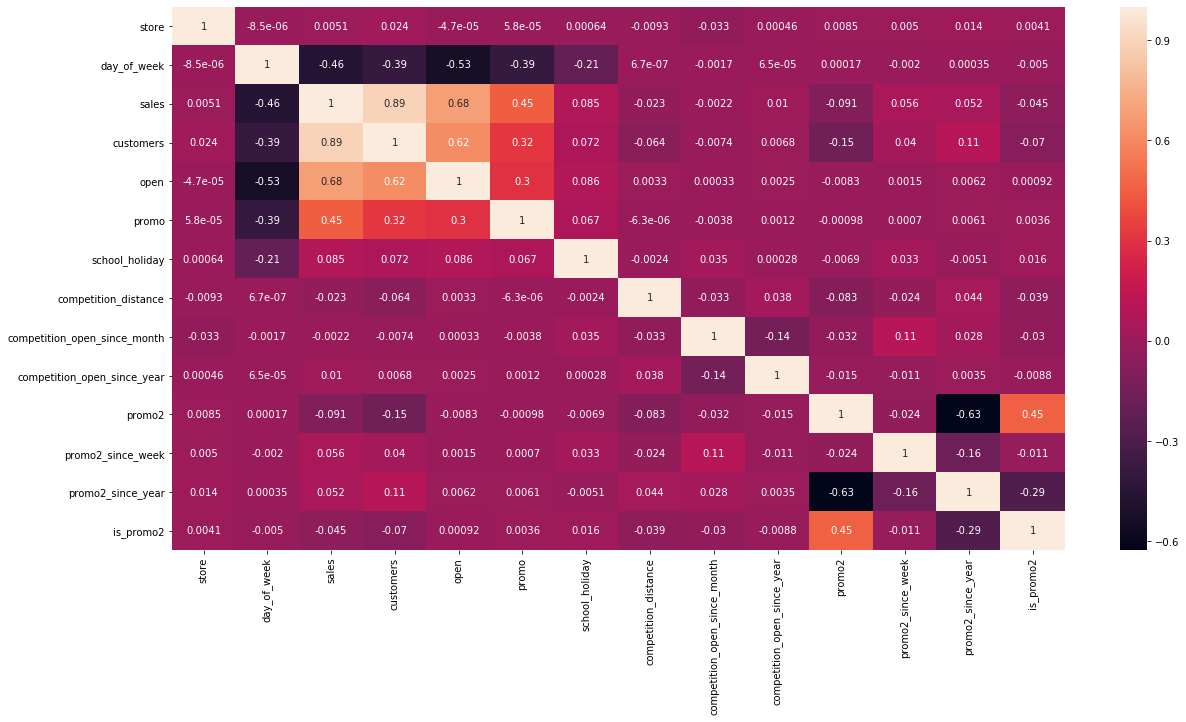

In [55]:
# On next run, consider uncommenting the line below
# num_attributes = df5.select_dtypes( exclude='object' )
sns.heatmap( num_attributes.corr( method = 'pearson'), annot=True );

### Categorical attributes

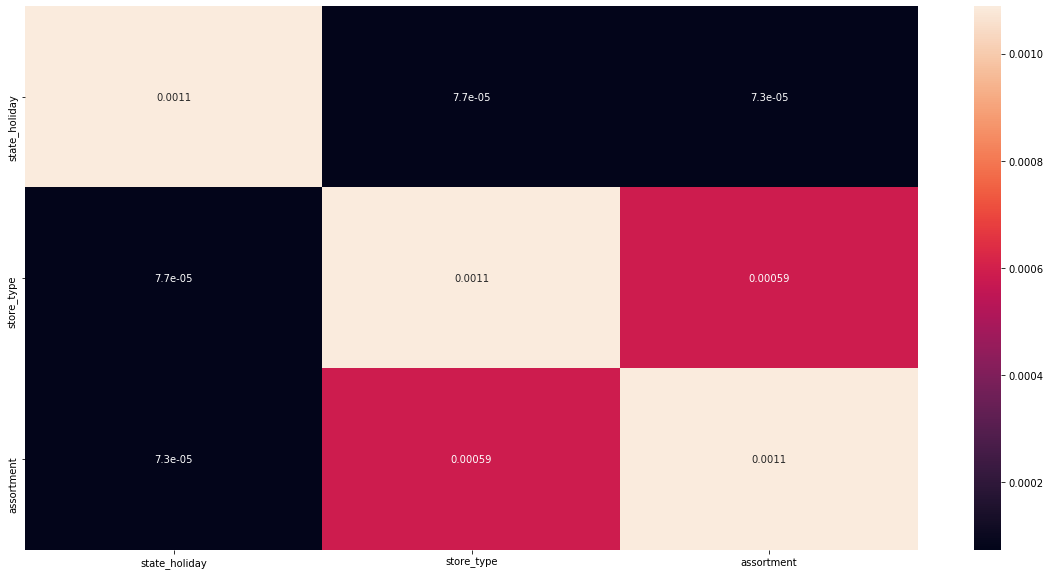

In [53]:
aux = df5.select_dtypes( include='object' )
aux = aux.drop( columns='year_week' )

a1 = cramerv( aux['state_holiday'], aux['state_holiday'] )
a2 = cramerv( aux['state_holiday'], aux['store_type'] )
a3 = cramerv( aux['state_holiday'], aux['assortment'] )

a4 = cramerv( aux['store_type'], aux['state_holiday'] )
a5 = cramerv( aux['store_type'], aux['store_type'] )
a6 = cramerv( aux['store_type'], aux['assortment'] )

a7 = cramerv( aux['assortment'], aux['state_holiday'] )
a8 = cramerv( aux['assortment'], aux['store_type'] )
a9 = cramerv( aux['assortment'], aux['assortment'] )

cat_corr = pd.DataFrame( { 'state_holiday':[a1, a2, a3],
                           'store_type':[a4, a5, a6],
                           'assortment':[a7, a8, a9] } )

cat_corr = cat_corr.set_index( cat_corr.columns )

sns.heatmap( cat_corr, annot=True );

# DATA PREPARATION

In [49]:
df6 = df5.copy()

## Rescaling

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

df6.loc[:,'competition_distance'] = rs.fit_transform( df6.loc[:,['competition_distance']] )

df6.loc[:,'competition_time_month'] = rs.fit_transform( df6.loc[:,['competition_time_month']] )

df6.loc[:,'promo_time_week'] = mms.fit_transform( df6.loc[:,['promo_time_week']] )

df6.loc[:,'year'] = mms.fit_transform( df6.loc[:,['year']] )

## Transformation

### Categorical variables encoding

In [65]:
# state_holiday - One Hot Encoding
df6 = pd.get_dummies( df6, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df6.loc[:,'store_type'] = le.fit_transform( df6.loc[:,'store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 0, 'extra': 1, 'extended': 2}
df6.loc[:,'assortment'] = df6.loc[:,'assortment'].map( assortment_dict )

### Nature transformation

In [66]:
# sales - Target variable
df6.loc[:,'sales'] = np.log1p( df6.loc[:,'sales'] )

In [67]:
# day_of_week
df6.loc[:,'day_of_week_sin'] = df6.loc[:,'day_of_week'].apply( lambda x: np.sin( x*2*np.pi/7 ) )
df6.loc[:,'day_of_week_cos'] = df6.loc[:,'day_of_week'].apply( lambda x: np.cos( x*2*np.pi/7 ) )

# month
df6.loc[:,'month_sin'] = df6.loc[:,'month'].apply( lambda x: np.sin( x*2*np.pi/12 ) )
df6.loc[:,'month_cos'] = df6.loc[:,'month'].apply( lambda x: np.cos( x*2*np.pi/12 ) )

# day
df6.loc[:,'day_sin'] = df6.loc[:,'day'].apply( lambda x: np.sin( x*2*np.pi/30 ) )
df6.loc[:,'day_cos'] = df6.loc[:,'day'].apply( lambda x: np.cos( x*2*np.pi/30 ) )

# week_of_year
df6.loc[:,'week_of_year_sin'] = df6.loc[:,'week_of_year'].apply( lambda x: np.sin( x*2*np.pi/52 ) )
df6.loc[:,'week_of_year_cos'] = df6.loc[:,'week_of_year'].apply( lambda x: np.cos( x*2*np.pi/52 ) )

In [68]:
df6.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
693901,42,4,2013-10-17,8.933796,0,0,0,2,-0.329032,10,...,0,1,-0.433884,-0.900969,-0.866025,0.500000,-4.067366e-01,-0.913545,-0.935016,0.354605
905899,190,3,2013-04-10,8.866723,1,0,0,0,-0.138710,12,...,0,1,0.433884,-0.900969,0.866025,-0.500000,8.660254e-01,-0.500000,0.970942,-0.239316
694936,1077,4,2013-10-17,8.119994,0,0,0,0,0.229032,11,...,0,1,-0.433884,-0.900969,-0.866025,0.500000,-4.067366e-01,-0.913545,-0.935016,0.354605
467777,263,4,2014-05-08,8.156510,1,0,0,2,-0.191935,5,...,0,1,-0.433884,-0.900969,0.500000,-0.866025,9.945219e-01,-0.104528,0.748511,-0.663123
966200,281,5,2013-02-15,8.539933,0,0,3,2,0.748387,9,...,0,1,-0.974928,-0.222521,0.866025,0.500000,5.665539e-16,-1.000000,0.748511,0.663123


# FEATURE SELECTION

In [69]:
df7 = df6.copy()

## Data split (training and test)

In [70]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df7 = df7.drop( cols_drop, axis=1 )

In [71]:
date_threshold = df7.loc[:,['store','date']].groupby('store').max().reset_index().loc[0,'date'] - datetime.timedelta( weeks=6 )

In [72]:
X_train = df7.loc[df7.loc[:,'date'] < date_threshold,:]
y_train = X_train.loc[:,'sales']

X_test = df7.loc[df7.loc[:,'date'] >= date_threshold,:]
y_test = X_test.loc[:,'sales']

print( 'Min. date for training set: {}'.format( X_train.loc[:,'date'].min() ) )
print( 'Max. date for training set: {}'.format( X_train.loc[:,'date'].max() ) )

print( 'Min. date for test set: {}'.format( X_test.loc[:,'date'].min() ) )
print( 'Max. date for test set: {}'.format( X_test.loc[:,'date'].max() ) )

Min. date for training set: 2013-01-01 00:00:00
Max. date for training set: 2015-06-18 00:00:00
Min. date for test set: 2015-06-19 00:00:00
Max. date for test set: 2015-07-31 00:00:00


## Boruta as a feature selector

In [73]:
# Preparing arrays from dataframes 
X_train_n = X_train.drop( columns=['date','sales'] ).values
y_train_n = y_train.values.ravel()

# Preparing Random Forest
rf = RandomForestRegressor( n_jobs=-1 )

# Defining boruta (can be run only once, results are displayed in the section below)
### boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )
### cols_selected = X_train.drop(columns=['date','sales']).columns[boruta.support_].to_list()
### cols_not_selected = list( np.setdiff1d( X_train.drop(columns=['date','sales']).columns, cols_selected ) )

### Results of the selection

In [74]:
# Below are the boruta output's copied for future runs
cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_cos']

cols_not_selected = [
    'is_start_promo2',
    'month_sin',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'week_of_year_sin',
    'year']

In [154]:
# Completing the output with missing sines/cosines
cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']


cols_not_selected = [
    'is_start_promo2',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'year']


feat_to_add = ['date', 'sales']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend( feat_to_add )

# MACHINE LEARNING MODELING

In [155]:
x_train = X_train[ cols_selected ].copy()
x_test = X_test[ cols_selected ].copy()

x_training = X_train.loc[:,cols_selected_full]

## Average Model (baseline)

In [77]:
aux1 = x_test.copy()
aux1.loc[:,'sales'] = y_test.copy()

# Prediction
aux2 = aux1.loc[:,['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1.loc[:,'predictions']

# Performance
baseline_result = ml_error( 'Average', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model name,MAE,MAPE,RMSE
0,Average,1354.800353,0.455051,1835.135542


## Linear Regression Model

In [159]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression,1865.508533,0.292454,2671.455737


### Cross-validation

In [156]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=True )


KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4


In [158]:
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.83 +/- 295.43,0.3 +/- 0.02,2954.51 +/- 467.88


## Regularized Linear Regression Model - Lasso

In [167]:
# Model
lasso = Lasso( alpha=0.01 ).fit( x_train, y_train )

# Prediction
yhat_lasso = lasso.predict( x_test )

# Performance
lasso_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lasso ) )
lasso_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1890.963877,0.289032,2744.757584


### Cross-validation

In [168]:
lasso_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=True )


KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4


In [169]:
lasso_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.58 +/- 341.36,0.29 +/- 0.01,3058.93 +/- 504.0


## Random Forest Regressor

In [81]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict( x_test )

# Performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.230369,0.100007,1011.306127


### Cross-validation

In [171]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )


KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4


In [172]:
rf_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.11 +/- 218.98,0.12 +/- 0.02,1256.33 +/- 319.73


## XGBoost Regressor

In [82]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# Prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,864.300245,0.125681,1281.783105


### Cross-validation

In [173]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )


KFold number: 0


d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold number: 1


d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold number: 2


d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold number: 3


d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold number: 4


d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
d:\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [174]:
xgb_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1033.32 +/- 179.16,0.14 +/- 0.02,1479.55 +/- 247.19


## Comparing models performances

### Single performance

In [170]:
modeling_results = pd.concat( [baseline_result, lr_result, lasso_result, rf_result, xgb_result] ).sort_values( 'RMSE' ).reset_index( drop=True )
modeling_results

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.230369,0.100007,1011.306127
1,XGBoost Regressor,864.300245,0.125681,1281.783105
2,Average,1354.800353,0.455051,1835.135542
3,Linear Regression,1865.508533,0.292454,2671.455737
4,Linear Regression - Lasso,1890.963877,0.289032,2744.757584


### Real performance - Cross-validation

In [179]:
modeling_results_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] ).sort_values( 'RMSE CV' ).reset_index( drop=True )
modeling_results_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.11 +/- 218.98,0.12 +/- 0.02,1256.33 +/- 319.73
1,XGBoost Regressor,1033.32 +/- 179.16,0.14 +/- 0.02,1479.55 +/- 247.19
2,Linear Regression,2081.83 +/- 295.43,0.3 +/- 0.02,2954.51 +/- 467.88
3,Lasso,2116.58 +/- 341.36,0.29 +/- 0.01,3058.93 +/- 504.0


## <s>Normalization</s>
Checking the univariate EDA, one sees that no distribution is close to normal, to which normalization (`preprocessing.StandardScaler`) would be best suited

# HYPERPARAMETER FINE TUNING

_Currently being built_